<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Евгений! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>



---
    
Для лучшей коммуникации будет лучше если ты будешь оставлять ответные комментарий (cвои комментарии к исправлениям, вопросы), так результат будет лучше.  А чтобы ревьюры их не теряли, лучше их подсвечивать цветом (можешь выбрать свой, а можешь использовать   тот который я предложил ниже). И чтобы не возникло путаницы лучше оставлять указание на номер версии комментария по итерация:  

1 итерация

<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Привет Марат!.</div>


2 итерация

<div class="alert alert-info"> <b>Комментарии студентаV2:</b> Исправлено.... </div>
    
    
И лучше подсвечивать свои комментарии цветом, для этого достаточно в ячейку markdown добавить: 

```html
<div class="alert alert-info"> <b>Комментарии студентаV2:</b> Исправлено.... </div>    

```    
    
Хорошая коммуникация залог успеха! )
    
---

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

    Проект выполнен с BERT!

In [1]:
!pip install -qq datasets
!pip install -qq evaluate

In [2]:
import gc
import numpy as np
import pandas as pd
import evaluate
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
import transformers
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, get_scheduler, BertForSequenceClassification, BertTokenizer, TextClassificationPipeline

/mnt/xpg/python_projects/classification_text/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Transformers version: 4.51.3
PyTorch version: 2.7.0+cu128
CUDA available: True


    Transformers version: 4.51.3
    PyTorch version: 2.7.0+cu128
    CUDA available: True

In [4]:
RANDOM_STATE = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Здорово что предусмотрена возможность использования GPU


 

    Импорт библиотек и настройка окружения

In [5]:
data = pd.read_csv("datasets/toxic_comments.csv") # добавить /

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 


Если не знаешь - чтобы не было столбца  `Unnamed: 0` при чтении файла можно так:


    pd.read_csv(..., index_col=0)

    
(`Unnamed: 0` появляется при не совсем корректном сохранении файла)    


Unnamed: 0 это "след" старых индексов. Если ты уберёшь первые 10 примеров и своего датасета, сохранишь его, а потом откроешь,  то появится столбец Unnamed: 0 начиная с цифры 9, и появится новый индексы начиная с нуля 


Но это мелочь,  даже не нужно ничего исправлять. Просто знай, чтобы увидев такое в чужом коде не удивляться что бы это могло означать

In [6]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


    Всего у нас 159 тысяч текстов 16 тысяч из которых токсичные комментарии, в целом этого более чем хватит

In [9]:
data = data[['text', 'toxic']]
data.columns = ['text', 'labels']

    Поделил колонки для удобства на две текст и лейбл

<Axes: >

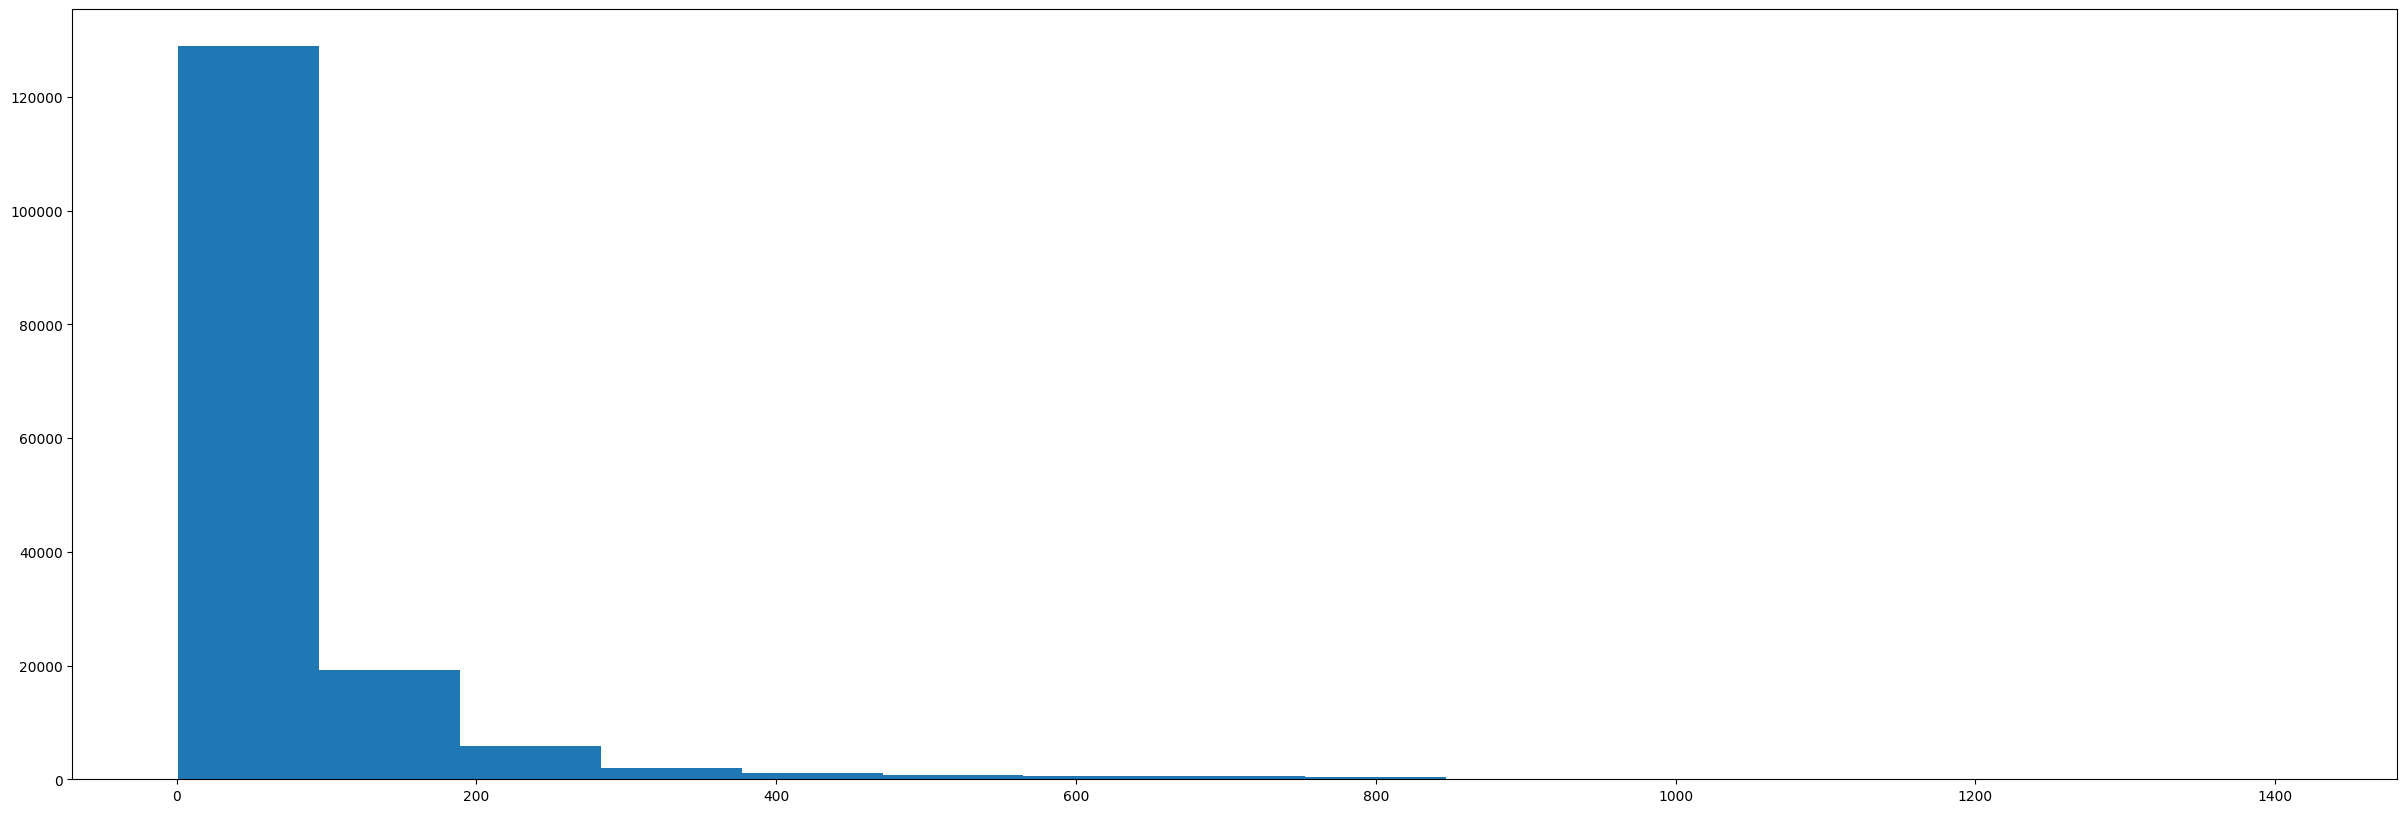

In [10]:
data['text'].apply(lambda x: len(x.split())).hist(figsize=(30, 10), bins=15, grid=False)

    Большинство текстов длинной около 300 символом, для удобства буду использовать вектор длинной 256

In [11]:
data = data.sample(frac=1).reset_index(drop=True)
train = data[:int(len(data)*0.8)]
test =  data[int(len(data)*0.8):]

In [12]:
len(train), len(test)

(127433, 31859)

In [13]:
print(len(train['labels'].value_counts()))

2


In [14]:
print(len(test['labels'].value_counts()))

2


In [15]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

    Данные поделены на тренировочную и тестовую выборки, на тестовую выделено 20 процентов даннх, в обоих выборках есть по два лейбла

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Данные изучены. Небольшой EDA не помешает, так как это аналитический проект. 


Плюс за   проверку на сбалансированность 
 


<div class="alert alert-warning">

Совет: 


 


- можно также посчитать количество слов в предложений,  длину слов в твите, опять же в разбивке по Таргету.  Если будут какие-то сильные отличия, возможно из-за этого стоит сгенерировать дополнительные признаки для наших моделей. Или например можно использовать библиотеку SentimentIntensityAnalyzer для оценки сантиментов, и посмотреть насколько хорошо ее оценки корелирует с нашими таргетами
   
   
- когда мы работаем с текстами, describe итп описательные статистике не использовать, но можно провести частотный анализ текста.  Предлагаю для этого использовать [облако слов](https://habr.com/ru/post/517410/) - чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах (в облаке уже автоматически будут убраны стоп слова). Кроме того графики, рисунки делают проект визуально интересней
   
   
В тренажере облако импортируем так

    !pip install wordcloud 


или

    !pip install wordcloud==1.8.2.2  


И возможно дополнительно надо будет сделать



    !pip install --upgrade Pillow  (попробуй версию 9.5.0)
 

## Обучение

In [16]:
model_name = "JungleLee/bert-toxic-comment-classification"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    В обучении буду использовать модель BERT JungleLee/bert-toxic-comment-classification

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:
    
    
    
    
    
Можешь зайти на huggingface, там огромное множество моделей, обученные на разных текстах. Посмотрим что будет с метрикой после исправления ошибки ниже

In [17]:
torch.cuda.empty_cache()
gc.collect()

56

In [18]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

    Перенос модели на гпу

In [19]:
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Generating train split: 127433 examples [00:00, 305339.45 examples/s]
Generating test split: 31859 examples [00:00, 311806.00 examples/s]


In [20]:
dataset = dataset.map(lambda x: tokenizer(x['text'], truncation = True, max_length=255, padding='max_length'), batched=True)

Map: 100%|██████████| 31859/31859 [00:21<00:00, 1467.87 examples/s]


In [21]:
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns)))

Предоставил BERT'у специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают позитивную эмоциональную окраску, единицы - негативную.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.
- **token_type_ids** Указывает является ли последовательность «контекстом», используемый для вопроса (все токены 0) или «вопросому» (все токены 1).

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127433
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31859
    })
})

In [23]:
dataset.set_format(type='torch', columns=pytorch_style_columns, device='cuda') # убрать здесь

In [ ]:
# 3 батча обучалось на 4070 на 12 гб под забивку памяти +- 11.9 гб
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=3)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=1)

In [25]:
len(train_dataloader)

63717

    Перевел в формат пайторча. Загрузил на гпу, если есть cuda, иначе девайс стоит убрать из аргумента  

In [26]:
optimizer = AdamW(model.parameters(), lr=2e-6)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

In [27]:
gc.collect()
torch.cuda.empty_cache()

In [28]:
# лучший f1, по нему будем сохранять
best_f1 = 0.
# средний loss
avg_loss = deque([], maxlen=50)

# проходимся по всем эпохам
for epoch in range(num_epochs):
    # отображаем номера эпох
    print(40*'-', '\nepoch', epoch+1)
    # переводим в режим тренировки
    model.train()
    # итерируемся по треин части
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            # переводим в режим тренировки
            model.train()
            # переносим батч на гпу, где и модель
            batch = {k: v.to(device) for k, v in batch.items()}
            # получаем прогнозы
            outputs = model(**batch)
            # получаем лосс встроенный вместе с моделью (кросс-энтропия)
            loss = outputs.loss
            # делаем обратный проход
            loss.backward()
            # шаг по градиенту
            optimizer.step()
            # шаг по скорости
            lr_scheduler.step()
            # шаг по оптимизатору
            optimizer.zero_grad()
            # фиксируем потери на треин
            avg_loss.append(loss.item())
            # добавляем в прогрессбар информацию о среднем лоссе за 50 батчей
            tepoch.set_postfix(loss=np.array(list(avg_loss)).mean())

    losses = []
    # валидируемся в конце эпохи
    print('\nvalidating')
    # загружаем все основные метрики
    f1 = evaluate.load('f1')
    acc = evaluate.load('accuracy')
    precision = evaluate.load('precision')
    recall = evaluate.load('recall')
    with torch.no_grad():
        # переводим в режим валидации
        model.eval()
        # проходимся по всем батчам из теста
        for batch in tqdm(test_dataloader):
            # переносим их на гпу
            batch = {k: v.to(device) for k, v in batch.items()}
            # не обновляя параметры получаем прогнозы
            with torch.no_grad():
                outputs = model(**batch)
            # получаем сразу логиты
            logits = outputs.logits
            # находим верный ответ
            predictions = torch.argmax(logits, dim=-1)
            # логируем в метрики по f1
            f1.add_batch(predictions=predictions, references=batch["labels"])
            acc.add_batch(predictions=predictions, references=batch["labels"])
            precision.add_batch(predictions=predictions, references=batch["labels"])
            recall.add_batch(predictions=predictions, references=batch["labels"])
        # находим стандартные метрики (без взвешивания)
        print('Test metrics:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute()['precision'])
        print('Test recall:', recall.compute()['recall'])
        f1_score = f1.compute()['f1']  # Используем стандартный F1 без average='weighted'
        print('Test f1:', f1_score, '\n')
        # если текущая f1 лучше максимальной
        if f1_score > best_f1:
            # максмальная становится текущей
            best_f1 = f1_score
            # сохраняем модель
            model.save_pretrained(f"best_model_f1_max={best_f1}_len=255")

    # переводим обратно в режим тренировки для следующей эпохи
    model.train()

---------------------------------------- 
epoch 1


100%|██████████| 63717/63717 [54:22<00:00, 19.53batch/s, loss=0.0807] 



validating


100%|██████████| 31859/31859 [03:37<00:00, 146.20it/s]


Test metrics:
Test acc: 0.9754229574060705
Test precision: 0.8431044109436069
Test recall: 0.9318111693921629
Test f1: 0.8852410962919537 



<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:



Ты искусственно завышаешь метрику используя     weighted, по условию используем дефолтный f1
    
    
<div class="alert alert-warning">
 

Совет 🤔:



- Можешь ознакомиться c [Trainer](https://pytorch-lighting.readthedocs.io/en/latest/common/trainer.html), который позволяет избежать простыней кода с циклами, в которых мы вычисляем функцию ошибки и двигаемся по антиградиенту
    
    
    
- С другой стороны весьма полезно написать  цикл со всеми стадиями обучения, но тогда могу предожить добавить график, для демонстрации улучшение метрики на валидационные выборке по итерациям   



<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Поменял на обычную метрику, теперь она 0.885, также поменял модель на JungleLee/bert-toxic-comment-classification</div>

    Каждый шаг обучения закомментировал, по итогу обучения модели у нас получились такие метрики:

        Test acc: 0.9754229574060705
        Test precision: 0.8431044109436069
        Test recall: 0.9318111693921629
        Test f1: 0.8852410962919537
    
    Точность у модели очень высокая, метрика f1 равна 0.885, значение удовлетворяет условию задачи

Обучение длилось +- 2.5 часа

In [29]:
# валидируем по тесту
# реальные ответы и предсказания
true = []
preds = []

# переводим модель в режим инференса
model.eval()
# проходимся по батчам теста
for batch in tqdm(test_dataloader):
    # переносим батч на GPU
    batch = {k: v.to(device) for k, v in batch.items()}
    # без обновления параметров находим прогнозы
    with torch.no_grad():
        outputs = model(**batch)
    # получаем логиты
    logits = outputs.logits
    # из логитов прогноз
    predictions = torch.argmax(logits, dim=-1)
    # добавляем пачки ответов и прогнозов в массивы
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

100%|██████████| 31859/31859 [03:05<00:00, 171.55it/s]


In [30]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     28618
           1       0.84      0.93      0.89      3241

    accuracy                           0.98     31859
   macro avg       0.92      0.96      0.94     31859
weighted avg       0.98      0.98      0.98     31859



    Предикты записаны, выведен отчет, класс с позитивными комментариями определяется почти совершенно точно, класс с негативными определяется чуть хуже, но все равно на высоком урвоне

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 

 

Как мы можем еще использовать Берт?   Можем его использовать чтобы получить эмбединги и подать их в наши модели как альтернативу векторов от TFIDF/CountVectorizer (чтобы это реализовать можно взять готовый код в тренажёре) - Таким образом мы получаем, (если выбрать верную модель)  метрику за 0,9. Это случай рекомендую использовать toxic-bert ( в этом случае разрешается использовать выборку в 2.000 примеров)
    
Подгрузить можно так
    
    
    model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
    tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')    
    
    
    
 


- Можно попробовать TFIDF, это устаревший подход, но зато есть возможность попрактиковаться в использовании связки pipeline+gridsearch и лемматизации (там есть свои тонкости). А в конце можно посмотреть какие слова модель считают наиболее важными




 

## Выводы

    Задача проекта была создать классификатор комментариев на позитивные и негативные для нового сервиса интернет-магазина «Викишоп», также основное условие, чтобы модель имела f1-score выше 0.75.
    
    Для решения задачи были проделаны следующие шаги:

        -Загрузка, описание и изучение данных
        -Предобработка данных и подготовка
        -Обучение модели
    
    В качестве модели была выбрана модель BERT'а - JungleLee/bert-toxic-comment-classification, метрика f1 равна 0.885, модель успешно справилась с задачей.
    В целом, можно улучшить метрику, для этого нужно побольше данных: пол, возраст, страна проживания людей, которые пишут комментарии.



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Евгений, у тебя старательно выполненная работа, все четко, осмысленно. 

 
Здорово что попробуй продвинутый подход с использованием Берта





Можешь доработать проект:



- можно попробовать по-другому использовать Берт/Можно использовать устаревший подход с TFIDF. плюсы в том что потренируешься в леоматизации, и использование pipeline, чтобы не было утечки данных.  Кроме того когда использую TFIDF, можно получить яркие оценки важности слов (самым важным окажется слово fuck) 

 

- для красивой  визуализации можешь построить облако для токсичных и нетоксичных комментариев



- чтобы заглянуть внутрь модели, можешь посмотреть какой из признаков является наиболее важный  

 


Обязательное к исправлению:

 

- не используем average='weighted/average='macro', так мы искусственно завышаем метрику

 




Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html 


Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .

Если нравится смотреть и слушать то есть целый курс на Ютубе https://www.youtube.com/watch?v=qDMwIQRQt-M&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=1


<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Подправил выводы, спасибо за ревью и кучу полезной инфы, обязательно поюзаю, желтые замечания, выглядит интересно, так как такое редкость, если несложно и можно, можешь скинуть также ссылки по компьютерному зрению, потому что обычно ничего такого не кидают</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны